<h1><font color=darkcyan>Imports

In [1]:
%%capture
!pip install transformers

# PyTorch libraries
import torch
from torch.utils.data import TensorDataset, DataLoader

# Tensorflow libraries
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import tensorflow_datasets as tfds

import numpy as np
import re
from keras.preprocessing.sequence import pad_sequences
from time import time
import seaborn as sns

import IPython
from IPython.display import clear_output 
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

# <h1><font color=indigo>Dataset

In [2]:
data = pd.read_csv('/content/drive/MyDrive/Emotion_final.csv')


In [3]:
data.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


# <h1><font color=darkmagneta>Visualization

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


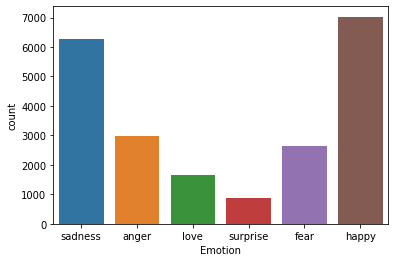

In [4]:
sns.countplot(data['Emotion'])

# <h3><font color>Histogram of sequence lenght
To find the Appropriate max lenght for training phase, we use the histogram below.
The horizontal axis shows the lenght of a sentence and the vertical axis shows frequency of samples with that lenght. 
As we can see, the proper maximum lenght to be passed to our neural network model is about 40.
We can choose bigger lenght but it doesnt have much impact on the accuracy( it only increases ram usage )

65


(0.0, 980.0)

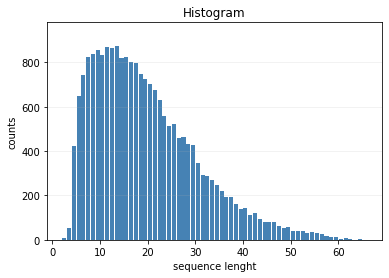

In [5]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in data['Text']]

n, bins, patches = plt.hist(seq_len, bins='auto', color='steelblue',
                            alpha=1, rwidth=0.85)
print(len(bins))
plt.grid(axis='y', alpha=0.2)
plt.xlabel('sequence lenght')
plt.ylabel('counts')
plt.title('Histogram')

maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 9) * 10 if maxfreq % 10 else maxfreq + 10)

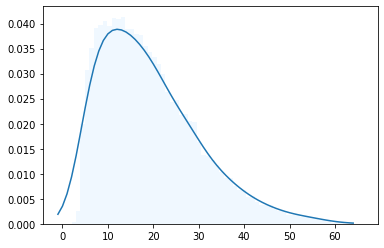

In [6]:
# example of kernel density estimation for a bimodal data sample
from matplotlib import pyplot
from numpy.random import normal
from numpy import hstack
from numpy import asarray
from numpy import exp
from sklearn.neighbors import KernelDensity

sample = np.array(seq_len).reshape(-1,1)
# fit density
model = KernelDensity(bandwidth=3, kernel='gaussian')
sample = sample.reshape((len(sample), 1))
model.fit(sample)
# sample probabilities for a range of outcomes
values = asarray([value for value in range(-1, 65)])
values = values.reshape((len(values), 1))
probabilities = model.score_samples(values)
probabilities = exp(probabilities)
# plot the histogram and pdf
pyplot.hist(sample, bins=65, density=True , color = 'aliceblue')
pyplot.plot(values[:], probabilities)
pyplot.show()

## removing punctuation

In [7]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [8]:
def remove_punctuation(text):
    no_punct=[words for words in text if words not in string.punctuation]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct
data['text_wo_punct']=data['Text'].apply(lambda x: remove_punctuation(x))
data.head()

,Text,Emotion,text_wo_punct
0,i didnt feel humiliated,sadness,i didnt feel humiliated
1,i can go from feeling so hopeless to so damned...,sadness,i can go from feeling so hopeless to so damned...
2,im grabbing a minute to post i feel greedy wrong,anger,im grabbing a minute to post i feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,love,i am ever feeling nostalgic about the fireplac...
4,i am feeling grouchy,anger,i am feeling grouchy


## tokenization

In [9]:
def tokenize(text):
    split=re.split("\W+",text) 
    return split
data['text_wo_punct_split']=data['text_wo_punct'].apply(lambda x: tokenize(x.lower()))
data.head()

,Text,Emotion,text_wo_punct,text_wo_punct_split
0,i didnt feel humiliated,sadness,i didnt feel humiliated,"[i, didnt, feel, humiliated]"
1,i can go from feeling so hopeless to so damned...,sadness,i can go from feeling so hopeless to so damned...,"[i, can, go, from, feeling, so, hopeless, to, ..."
2,im grabbing a minute to post i feel greedy wrong,anger,im grabbing a minute to post i feel greedy wrong,"[im, grabbing, a, minute, to, post, i, feel, g..."
3,i am ever feeling nostalgic about the fireplac...,love,i am ever feeling nostalgic about the fireplac...,"[i, am, ever, feeling, nostalgic, about, the, ..."
4,i am feeling grouchy,anger,i am feeling grouchy,"[i, am, feeling, grouchy]"


In [10]:
## removing stopwords

In [11]:
import nltk
nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english')
print(stopword[:11])
def remove_stopwords(text):
    text=[word for word in text if word not in stopword]
    return text
data['text_wo_punct_split_wo_stopwords'] = data['text_wo_punct_split'].apply(lambda x: remove_stopwords(x))
data.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've"]


,Text,Emotion,text_wo_punct,text_wo_punct_split,text_wo_punct_split_wo_stopwords
0,i didnt feel humiliated,sadness,i didnt feel humiliated,"[i, didnt, feel, humiliated]","[didnt, feel, humiliated]"
1,i can go from feeling so hopeless to so damned...,sadness,i can go from feeling so hopeless to so damned...,"[i, can, go, from, feeling, so, hopeless, to, ...","[go, feeling, hopeless, damned, hopeful, aroun..."
2,im grabbing a minute to post i feel greedy wrong,anger,im grabbing a minute to post i feel greedy wrong,"[im, grabbing, a, minute, to, post, i, feel, g...","[im, grabbing, minute, post, feel, greedy, wrong]"
3,i am ever feeling nostalgic about the fireplac...,love,i am ever feeling nostalgic about the fireplac...,"[i, am, ever, feeling, nostalgic, about, the, ...","[ever, feeling, nostalgic, fireplace, know, st..."
4,i am feeling grouchy,anger,i am feeling grouchy,"[i, am, feeling, grouchy]","[feeling, grouchy]"


## lemmatization

In [12]:

# import these modules
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]  ##Notice the use of text.

def join_lem(text):
  return ' '.join(w for w in text)

data['Text'] = data["text_wo_punct_split_wo_stopwords"].apply(lemmatize_text)
data['Text'] = data['Text'].apply(join_lem)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
data = data.filter(['Text','Emotion'])

In [14]:
data

,Text,Emotion
0,didnt feel humiliated,sadness
1,go feeling hopeless damned hopeful around some...,sadness
2,im grabbing minute post feel greedy wrong,anger
3,ever feeling nostalgic fireplace know still pr...,love
4,feeling grouchy,anger
...,...,...
21454,melissa stared friend dism,fear
21455,successive state election seen governing party...,fear
21456,vincent irritated dismay,fear
21457,kendallhume turned back face dismayed coup,fear


Since the machine learning model can only process numerical data, we need to convert the emotion column strings into a numerical format.
We then add a new column with corresponding numerical value to each emotion.

In [15]:
possible_labels = data.Emotion.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict


{'anger': 1, 'fear': 4, 'happy': 5, 'love': 2, 'sadness': 0, 'surprise': 3}

In [16]:
data['label'] = data.Emotion.replace(label_dict)
data

,Text,Emotion,label
0,didnt feel humiliated,sadness,0
1,go feeling hopeless damned hopeful around some...,sadness,0
2,im grabbing minute post feel greedy wrong,anger,1
3,ever feeling nostalgic fireplace know still pr...,love,2
4,feeling grouchy,anger,1
...,...,...,...
21454,melissa stared friend dism,fear,4
21455,successive state election seen governing party...,fear,4
21456,vincent irritated dismay,fear,4
21457,kendallhume turned back face dismayed coup,fear,4


71


(0.0, 2110.0)

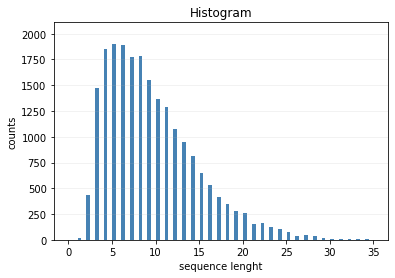

In [17]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in data['Text']]

n, bins, patches = plt.hist(seq_len, bins='auto', color='steelblue',
                            alpha=1, rwidth=0.85)
print(len(bins))
plt.grid(axis='y', alpha=0.2)
plt.xlabel('sequence lenght')
plt.ylabel('counts')
plt.title('Histogram')

maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 9) * 10 if maxfreq % 10 else maxfreq + 10)

In [18]:
from sklearn.model_selection import train_test_split

train, valid_test = train_test_split(data, test_size=0.4 , shuffle=True)

validate , test = train_test_split(valid_test, test_size=0.5 , shuffle=True)

## <h1><font color=indigo>1.4 Converting to Prefetched dataset

In [19]:
def convert_to_TF(data):
  data = tf.data.Dataset.from_tensor_slices((data['Text'],data['label']))
  data = data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  return data


In [20]:
# CONVERT TO TensorFlow DATASETS
train_dataset = convert_to_TF(train)

validation_dataset = convert_to_TF(validate)

test_dataset = convert_to_TF(test)

# **1. Matching Model**

## <h1><font color='darkcyan'>1.1 Pre proccessing

## <h1><font color='darkcyan'>1.2 Tokenization

In [21]:
def map_to_dict(input_ids, attention_mask, label):
    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask
    }, label


def encode_examples(ds, max_sequence_length):
    # prepare list, so that we can build up final TensorFlow dataset from slices.
    input_ids_list = []
    attention_mask_list = []
    labels = []

    #iterate over ds and extract input ids and attention masks for each sample
    for review, label in tfds.as_numpy(ds):
        bert_input = tokenizer( 
                        review.decode(),                    
                        add_special_tokens = True, # add [CLS], [SEP] default is True
                        max_length = max_sequence_length, # max length of the text that can go to BERT
                        padding='max_length', # add [PAD] tokens
                        return_attention_mask = True, # add attention mask to not focus on pad tokens
                        truncation = True
                       )
        input_ids_list.append(bert_input['input_ids'])
        attention_mask_list.append(bert_input['attention_mask'])
        labels.append(label)

    # reshape each list to (-1, max_sequence_length)
    input_ids_list = torch.tensor(input_ids_list, dtype=torch.int64).reshape(-1, max_sequence_length)
    attention_mask_list = torch.tensor(attention_mask_list, dtype=torch.int64).reshape(-1, max_sequence_length)
    labels = torch.tensor(labels, dtype=torch.int64).reshape(-1, 1)

    return TensorDataset(input_ids_list, attention_mask_list, labels)

## <h1><font color='darkcyan'>1.3 Encoding

In [22]:
# train dataset
# train dataset
from transformers import BertTokenizer , RobertaTokenizer , ElectraTokenizer , DistilBertTokenizer
"""google/electra-base-discriminator"""
"""google/electra-large-discriminator"""
tokenizer = RobertaTokenizer.from_pretrained("roberta-large" , do_lower_case=True)

batch_size = 128
max_sequence_length = 25

train_data_encoded = DataLoader(encode_examples(train_dataset, max_sequence_length) , batch_size = batch_size)
validation_data_encoded = DataLoader(encode_examples(validation_dataset , max_sequence_length) , batch_size= batch_size)


## <h1><font color='darkcyan'>1.4 Defining Model

In [23]:
from transformers import DistilBertForSequenceClassification , RobertaForSequenceClassification , XLNetModel , ElectraModel  , BertForSequenceClassification

from torch import nn
"""
"roberta-large"
"""
Bert = RobertaForSequenceClassification.from_pretrained("roberta-large", num_labels=len(label_dict))

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classi

In [24]:
model = Bert

### <h1><font color='darkcyan'>1.4.1 Names and Dimensions of layers 
The embedding layer,The first of the twelve transformers & The output layer.

In [25]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())
print('The  model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== First Transformer ====\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== Output Layer ====\n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The  model has 393 different named parameters.

==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight               (50265, 1024)
roberta.embeddings.position_embeddings.weight            (514, 1024)
roberta.embeddings.token_type_embeddings.weight            (1, 1024)
roberta.embeddings.LayerNorm.weight                          (1024,)
roberta.embeddings.LayerNorm.bias                            (1024,)

==== First Transformer ====

roberta.encoder.layer.0.attention.self.query.weight     (1024, 1024)
roberta.encoder.layer.0.attention.self.query.bias            (1024,)
roberta.encoder.layer.0.attention.self.key.weight       (1024, 1024)
roberta.encoder.layer.0.attention.self.key.bias              (1024,)
roberta.encoder.layer.0.attention.self.value.weight     (1024, 1024)
roberta.encoder.layer.0.attention.self.value.bias            (1024,)
roberta.encoder.layer.0.attention.output.dense.weight   (1024, 1024)
roberta.encoder.layer.0.attention.output.dense.bias          (1024

### <h1><font color='darkcyan'>1.4.2 Function to calculate the accuracy

In [26]:
from sklearn.metrics import f1_score
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [27]:
# Tell pytorch to run this model on the GPU.
device = 'cuda'
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
         

### <h1><font color='darkcyan'>1.4.3 Helper function for formatting elapsed times.


In [28]:
import time
import datetime
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

## <h1><font color='darkcyan'>1.5 HyperParameters

In [29]:
criterion = torch.nn.BCELoss()

epochs = 10

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr = 8e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8, # args.adam_epsilon  - default is 1e-8.
                  correct_bias = True
                )

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_data_encoded) * epochs
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 10, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## <h1><font color='darkcyan'>1.6 Training

In [30]:
# Multiply accumulation_steps by batch_size to perform gradient accumulation .

# Store the average loss after each epoch so we can plot them.
loss_values  = []

total_loss = 0

for i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    model.train()

    for i_batch, batch in enumerate(train_data_encoded):
        # Progress update every 100 batches.
        if i_batch % 10 == 0 and not i_batch == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(i_batch, len(train_data_encoded), elapsed))

        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        """Perform a forward pass (evaluate the model on this training batch)
        This will return the loss (rather than the model output) because we
        have provided the `labels`.
        The documentation for this `model` function is here """
        outputs = model.forward(input_ids=input_ids, attention_mask=attention_mask , labels = labels)

        # outputs = model(input_ids ,  attention_mask)


        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = None
        labels = labels.float()
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.                                                 
        optimizer.step()                
        
        model.zero_grad() 

    # Update the learning rate.                    
    scheduler.step()          
      
    avg_train_loss = total_loss / len(train_data_encoded)
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    print('')
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
    
        # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
    for batch in validation_data_encoded:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model.forward(input_ids=b_input_ids, attention_mask=b_input_mask , labels = b_labels)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.

        # Move logits and labels to CPU
        logits = outputs[1]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = f1_score_func(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy
        # Track the number of batches
        nb_eval_steps += 1
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")  




======== Epoch 1 / 10 ========
Training...
  Batch    10  of    101.    Elapsed: 0:00:10.
  Batch    20  of    101.    Elapsed: 0:00:20.
  Batch    30  of    101.    Elapsed: 0:00:29.
  Batch    40  of    101.    Elapsed: 0:00:39.
  Batch    50  of    101.    Elapsed: 0:00:49.
  Batch    60  of    101.    Elapsed: 0:00:59.
  Batch    70  of    101.    Elapsed: 0:01:08.
  Batch    80  of    101.    Elapsed: 0:01:18.
  Batch    90  of    101.    Elapsed: 0:01:28.
  Batch   100  of    101.    Elapsed: 0:01:38.

  Average training loss: 1.87
  Training epcoh took: 0:01:39

Running Validation...
  Accuracy: 0.03
  Validation took: 0:00:10

======== Epoch 2 / 10 ========
Training...
  Batch    10  of    101.    Elapsed: 0:00:10.
  Batch    20  of    101.    Elapsed: 0:00:20.
  Batch    30  of    101.    Elapsed: 0:00:29.
  Batch    40  of    101.    Elapsed: 0:00:39.
  Batch    50  of    101.    Elapsed: 0:00:49.
  Batch    60  of    101.    Elapsed: 0:00:59.
  Batch    70  of    101.    El

## <h1><font color='darkcyan'>1.7 Evaluation

In [31]:
# test dataset
batch_size = 128
max_sequence_length = 30

test_data_encoded = DataLoader(encode_examples(test_dataset, max_sequence_length) , batch_size = batch_size)

In [32]:
prediction_inputs = len(test_data_encoded)
m = torch.nn.Softmax(dim=1)
dict_arg = {}

In [33]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(prediction_inputs))
# Put model in evaluation mode
model.eval()
# Tracking variables 
predictions , true_labels = [], []
# Predict 
for batch in test_data_encoded:

  # Add batch to GPU
  batch = tuple(t.to('cuda') for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model.forward(input_ids=b_input_ids, attention_mask=b_input_mask , labels = b_labels)
  # Move logits and labels to CPU
  logits = outputs[1]
  logits = logits.detach().cpu().numpy()
  
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels

  # Calculate the accuracy for this batch of test sentences.
  tmp_eval_accuracy = f1_score_func(logits, label_ids)
  
  # Accumulate the total accuracy.
  eval_accuracy += tmp_eval_accuracy
  # Track the number of batches
  nb_eval_steps += 1
    # Report the final accuracy for this validation run.

  predictions.append(logits)
  true_labels.append(label_ids)
print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

print('DONE.')

Predicting labels for 34 test sentences...
  Accuracy: 0.93
DONE.


In [34]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [35]:
accuracy_per_class(predictions, true_labels)

Class: sadness
Accuracy: 1234/1269

Class: anger
Accuracy: 567/596

Class: love
Accuracy: 246/314

Class: surprise
Accuracy: 126/160

Class: fear
Accuracy: 471/526

Class: happy
Accuracy: 1334/1427



In [36]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

In [37]:
predictions = np.argmax(predictions, axis=1).flatten()
true_labels = true_labels.flatten()


In [38]:
precision_recall_fscore_support(predictions, true_labels, average='weighted')


(0.9283743778976329, 0.9268406337371855, 0.9273549980962889, None)

In [39]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(true_labels, predictions)

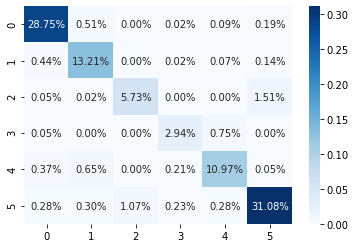

In [40]:
import seaborn as sns
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

# <h1><font color='darkcyan'>2. Augmentation

In [41]:
data_augmented = pd.read_csv('/content/drive/MyDrive/data even more !!!.csv')

In [42]:
data_augmented

,Unnamed: 0,Unnamed: 0.1,Text,Emotion
0,0,0,i didnt feel humiliated,sadness
1,1,1,i can go from feeling so hopeless to so damned...,sadness
2,2,2,im grabbing a minute to post i feel greedy wrong,anger
3,3,3,i am ever feeling nostalgic about the fireplac...,love
4,4,4,i am feeling grouchy,anger
...,...,...,...,...
29619,5640,2647,melissa stared hesitantly at her friend in dre...,fear
29620,5641,2648,successive state representation elections have...,fear
29621,5642,2649,vincent was irritated but yet not dismay,fear
29622,5643,2650,kendall - man hume turned back and to complete...,fear


## 2.1 removing punctuation

In [43]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [44]:
def remove_punctuation(text):
    no_punct=[words for words in text if words not in string.punctuation]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct
data_augmented['text_wo_punct']=data_augmented['Text'].apply(lambda x: remove_punctuation(x))
data_augmented.head()

,Unnamed: 0,Unnamed: 0.1,Text,Emotion,text_wo_punct
0,0,0,i didnt feel humiliated,sadness,i didnt feel humiliated
1,1,1,i can go from feeling so hopeless to so damned...,sadness,i can go from feeling so hopeless to so damned...
2,2,2,im grabbing a minute to post i feel greedy wrong,anger,im grabbing a minute to post i feel greedy wrong
3,3,3,i am ever feeling nostalgic about the fireplac...,love,i am ever feeling nostalgic about the fireplac...
4,4,4,i am feeling grouchy,anger,i am feeling grouchy


## 2.2 tokenization

In [45]:
def tokenize(text):
    split=re.split("\W+",text) 
    return split
data_augmented['text_wo_punct_split']=data_augmented['text_wo_punct'].apply(lambda x: tokenize(x.lower()))
data_augmented.head()

,Unnamed: 0,Unnamed: 0.1,Text,Emotion,text_wo_punct,text_wo_punct_split
0,0,0,i didnt feel humiliated,sadness,i didnt feel humiliated,"[i, didnt, feel, humiliated]"
1,1,1,i can go from feeling so hopeless to so damned...,sadness,i can go from feeling so hopeless to so damned...,"[i, can, go, from, feeling, so, hopeless, to, ..."
2,2,2,im grabbing a minute to post i feel greedy wrong,anger,im grabbing a minute to post i feel greedy wrong,"[im, grabbing, a, minute, to, post, i, feel, g..."
3,3,3,i am ever feeling nostalgic about the fireplac...,love,i am ever feeling nostalgic about the fireplac...,"[i, am, ever, feeling, nostalgic, about, the, ..."
4,4,4,i am feeling grouchy,anger,i am feeling grouchy,"[i, am, feeling, grouchy]"


In [46]:
import nltk
nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english')
print(stopword[:11])
def remove_stopwords(text):
    text=[word for word in text if word not in stopword]
    return text
data_augmented['text_wo_punct_split_wo_stopwords'] = data_augmented['text_wo_punct_split'].apply(lambda x: remove_stopwords(x))
data_augmented.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've"]


,Unnamed: 0,Unnamed: 0.1,Text,Emotion,text_wo_punct,text_wo_punct_split,text_wo_punct_split_wo_stopwords
0,0,0,i didnt feel humiliated,sadness,i didnt feel humiliated,"[i, didnt, feel, humiliated]","[didnt, feel, humiliated]"
1,1,1,i can go from feeling so hopeless to so damned...,sadness,i can go from feeling so hopeless to so damned...,"[i, can, go, from, feeling, so, hopeless, to, ...","[go, feeling, hopeless, damned, hopeful, aroun..."
2,2,2,im grabbing a minute to post i feel greedy wrong,anger,im grabbing a minute to post i feel greedy wrong,"[im, grabbing, a, minute, to, post, i, feel, g...","[im, grabbing, minute, post, feel, greedy, wrong]"
3,3,3,i am ever feeling nostalgic about the fireplac...,love,i am ever feeling nostalgic about the fireplac...,"[i, am, ever, feeling, nostalgic, about, the, ...","[ever, feeling, nostalgic, fireplace, know, st..."
4,4,4,i am feeling grouchy,anger,i am feeling grouchy,"[i, am, feeling, grouchy]","[feeling, grouchy]"


## 2.3 lemmatization

In [47]:

# import these modules
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]  ##Notice the use of text.

def join_lem(text):
  return ' '.join(w for w in text)

data_augmented['Text'] = data_augmented["text_wo_punct_split_wo_stopwords"].apply(lemmatize_text)
data_augmented['Text'] = data_augmented['Text'].apply(join_lem)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [48]:
data_augmented = data_augmented.filter(['Text','Emotion'])

In [49]:
data_augmented

,Text,Emotion
0,didnt feel humiliated,sadness
1,go feeling hopeless damned hopeful around some...,sadness
2,im grabbing minute post feel greedy wrong,anger
3,ever feeling nostalgic fireplace know still pr...,love
4,feeling grouchy,anger
...,...,...
29619,melissa stared hesitantly friend dread dism,fear
29620,successive state representation election seen ...,fear
29621,vincent irritated yet dismay,fear
29622,kendall man hume turned back completely face d...,fear


In [50]:
possible_labels = data_augmented.Emotion.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'anger': 1, 'fear': 4, 'happy': 5, 'love': 2, 'sadness': 0, 'surprise': 3}

In [51]:
data_augmented['label'] = data_augmented.Emotion.replace(label_dict)
data_augmented

,Text,Emotion,label
0,didnt feel humiliated,sadness,0
1,go feeling hopeless damned hopeful around some...,sadness,0
2,im grabbing minute post feel greedy wrong,anger,1
3,ever feeling nostalgic fireplace know still pr...,love,2
4,feeling grouchy,anger,1
...,...,...,...
29619,melissa stared hesitantly friend dread dism,fear,4
29620,successive state representation election seen ...,fear,4
29621,vincent irritated yet dismay,fear,4
29622,kendall man hume turned back completely face d...,fear,4


## <h1><font color=darkmagneta>2.4 Visualization

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


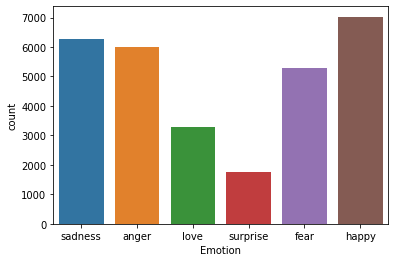

In [52]:
sns.countplot(data_augmented['Emotion'])

In [53]:
from sklearn.model_selection import train_test_split

train_aug, valid_test_aug = train_test_split(data_augmented, test_size=0.4 , shuffle=True)

validate_aug , test_aug = train_test_split(valid_test_aug, test_size=0.5 , shuffle=True)

In [54]:
# CONVERT TO TensorFlow DATASETS
train_dataset_aug = convert_to_TF(train_aug)

validation_dataset_aug = convert_to_TF(validate_aug)

test_dataset_aug = convert_to_TF(test_aug)

In [55]:
# train dataset
# train dataset
from transformers import BertTokenizer , RobertaTokenizer , ElectraTokenizer , DistilBertTokenizer
"""google/electra-base-discriminator"""
"""google/electra-large-discriminator"""
tokenizer = RobertaTokenizer.from_pretrained("roberta-large" , do_lower_case=True)

batch_size = 128
max_sequence_length = 25

train_data_encoded_aug = DataLoader(encode_examples(train_dataset_aug, max_sequence_length) , batch_size = batch_size)
validation_data_encoded_aug = DataLoader(encode_examples(validation_dataset_aug , max_sequence_length) , batch_size= batch_size)


## <h1><font color='darkcyan'>2.5 HyperParameters

In [56]:
model_aug = Bert
model_aug.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
         

In [57]:
criterion = torch.nn.BCELoss()

epochs = 10

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model_aug.parameters(),
                  lr = 8e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8, # args.adam_epsilon  - default is 1e-8.
                  correct_bias = True
                )

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_data_encoded_aug) * epochs
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 10, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [58]:
# Multiply accumulation_steps by batch_size to perform gradient accumulation .

# Store the average loss after each epoch so we can plot them.
loss_values  = []

total_loss = 0

for i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    model_aug.train()

    for i_batch, batch in enumerate(train_data_encoded_aug):
        # Progress update every 100 batches.
        if i_batch % 100 == 0 and not i_batch == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(i_batch, len(train_data_encoded_aug), elapsed))

        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        """Perform a forward pass (evaluate the model on this training batch)
        This will return the loss (rather than the model output) because we
        have provided the `labels`.
        The documentation for this `model` function is here """
        outputs = model_aug.forward(input_ids=input_ids, attention_mask=attention_mask , labels = labels)

        # outputs = model(input_ids ,  attention_mask)


        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = None
        loss_fct = torch.nn.BCELoss()
        labels = labels.float()
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.                                                 
        optimizer.step()                
        
        model_aug.zero_grad() 

    # Update the learning rate.                    
    scheduler.step()          
      
    avg_train_loss = total_loss / len(train_data_encoded_aug)
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    print('')
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
    
        # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model_aug.eval()
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
    for batch in validation_data_encoded_aug:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model_aug.forward(input_ids=b_input_ids, attention_mask=b_input_mask , labels = b_labels)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.

        # Move logits and labels to CPU
        logits = outputs[1]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = f1_score_func(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy
        # Track the number of batches
        nb_eval_steps += 1
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")  




======== Epoch 1 / 10 ========
Training...
  Batch   100  of    139.    Elapsed: 0:01:38.

  Average training loss: 0.25
  Training epcoh took: 0:02:16

Running Validation...
  Accuracy: 0.91
  Validation took: 0:00:14

======== Epoch 2 / 10 ========
Training...
  Batch   100  of    139.    Elapsed: 0:01:38.

  Average training loss: 0.19
  Training epcoh took: 0:02:16

Running Validation...
  Accuracy: 0.93
  Validation took: 0:00:14

======== Epoch 3 / 10 ========
Training...
  Batch   100  of    139.    Elapsed: 0:01:38.

  Average training loss: 0.15
  Training epcoh took: 0:02:16

Running Validation...
  Accuracy: 0.94
  Validation took: 0:00:14

======== Epoch 4 / 10 ========
Training...
  Batch   100  of    139.    Elapsed: 0:01:38.

  Average training loss: 0.13
  Training epcoh took: 0:02:16

Running Validation...
  Accuracy: 0.93
  Validation took: 0:00:14

======== Epoch 5 / 10 ========
Training...
  Batch   100  of    139.    Elapsed: 0:01:38.

  Average training loss: 0.1

## <h1><font color='darkcyan'>2.6 Evaluation

In [59]:
# test dataset
batch_size = 128
max_sequence_length = 60

test_data_encoded_aug = DataLoader(encode_examples(test_dataset_aug, max_sequence_length) , batch_size = batch_size)

In [60]:
prediction_inputs = len(test_data_encoded_aug)
m = torch.nn.Softmax(dim=1)
dict_arg = {}

In [61]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(prediction_inputs))
# Put model in evaluation mode
model_aug.eval()
# Tracking variables 
predictions , true_labels = [], []
# Predict 
for batch in test_data_encoded_aug:

  # Add batch to GPU
  batch = tuple(t.to('cuda') for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model_aug.forward(input_ids=b_input_ids, attention_mask=b_input_mask , labels = b_labels)
  # Move logits and labels to CPU
  logits = outputs[1]
  logits = logits.detach().cpu().numpy()
  
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels

  # Calculate the accuracy for this batch of test sentences.
  tmp_eval_accuracy = f1_score_func(logits, label_ids)
  
  # Accumulate the total accuracy.
  eval_accuracy += tmp_eval_accuracy
  # Track the number of batches
  nb_eval_steps += 1
    # Report the final accuracy for this validation run.

  predictions.append(logits)
  true_labels.append(label_ids)
print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

print('DONE.')

Predicting labels for 47 test sentences...
  Accuracy: 0.94
DONE.


In [62]:
accuracy_per_class(predictions, true_labels)

Class: sadness
Accuracy: 1207/1261

Class: anger
Accuracy: 1195/1219

Class: love
Accuracy: 645/669

Class: surprise
Accuracy: 356/366

Class: fear
Accuracy: 874/994

Class: happy
Accuracy: 1298/1416



In [63]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

In [64]:
predictions = np.argmax(predictions, axis=1).flatten()
true_labels = true_labels.flatten()


In [65]:
precision_recall_fscore_support(predictions, true_labels, average='weighted')


(0.9433303533718421, 0.9409282700421941, 0.9401424796645732, None)

In [66]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(true_labels, predictions)

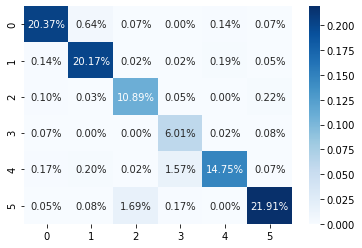

In [67]:
import seaborn as sns
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')